<a href="https://colab.research.google.com/github/AyushGupta51379/COMP_5331_Project_Fake_News_Detection/blob/master/pixel_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Upload datasets to google drive and mount it on Colab

In [1]:
import torch                       # pytorch
import torch.nn as nn              # pytorch for neural network
import torch.nn.functional as F
from torchvision import datasets, transforms # for loading and transform images to tensor
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt    # to plot graph
import time
from tqdm import tqdm

In [2]:
  
from google.colab import drive
from IPython.display import clear_output

drive.mount('/content/drive')
# ls 'drive/My Drive/

!unzip 'drive/My Drive/MM17-WeiboRumorSet.zip'

clear_output()
print("unzipping details have been cleared.")

unzipping details have been cleared.


# Read all images, resize images into (image_height,image_width), convert into tensor type

Reference/Tutorial
- A Beginner’s Tutorial on Building an AI Image Classifier using PyTorch **(from data loading, processing to training and evaluation)**
   - https://towardsdatascience.com/a-beginners-tutorial-on-building-an-ai-image-classifier-using-pytorch-6f85cb69cba7

In [3]:
# mainfolder = 'drive/My Drive/COMP5331 Fall 2020/MM17-WeiboRumorSet/'
mainfolder = 'MM17-WeiboRumorSet/'
image_height = 224
image_width  = 224
mytransform = transforms.Compose([transforms.Resize((image_height,image_width), interpolation=Image.NEAREST),   # to resize our source images
                                  transforms.ToTensor()])                                      # then convert into tensors 

dataset = datasets.ImageFolder(mainfolder, transform= mytransform) 
# NOTE: The path should point to a place with subfolders (which contain images inside).
#  It will report bugs if there is no subfolder.
# print(type(dataset))
print('Total no. of images: ', len(dataset))

print(round(len(dataset)*0.5))

# 80% train, 20% test
train_set, val_set = torch.utils.data.random_split(dataset, [round(len(dataset)*0.8), round(len(dataset)*0.2)])
print('Total no. of train set images: ', len(train_set))
print('Total no. of test set images: ', len(val_set))

labels = dataset.class_to_idx # the dataset saves the subfolder's name as the labels
# print(labels) 
# print(type(labels))

classes = list(labels.keys()) # convert dict keys into list
print('classes:', classes)


#  function to view one image
def image_show(np_image):
  plt.figure(figsize = (5,5))
  plt.imshow(np_image) # it should be a numpy array
  plt.show()

Total no. of images:  13249
6624
Total no. of train set images:  10599
Total no. of test set images:  2650
classes: ['nonrumor_images', 'rumor_images', 'tweets']


# Pixel-domain Network

`nn.Conv2d(in_channels, out_channels, kernel_size, ...)`
  - It seems we have to specify the in_channels *manually*

`nn.MaxPool2d(kernel_size, ...`

*   kernel_size = 3 --> 3 x 3
- Max pooling: The maximum pixel value is selected. Batch size and channel size are not changed.  
'the output value of the layer with input size (N, C, H, W), output $(N, C, H_{out}, W_{out})$'
- Min pooling: The minimum pixel value of the batch is selected.
- Average pooling: The average value of all the pixels in the batch is selected.

`nn.Linear(in_features, out_features, ...`

---
**Reference/Tutorial**
- Understand how kernels work in Conv2d and pooling
  -  https://stats.stackexchange.com/questions/296679/what-does-kernel-size-mean#:~:text=Deep%20neural%20networks%2C%20more%20concretely,layer%2C%20are%20the%20convolutional%20filters.

- Convolution Neural Network (CNN)
  -  https://towardsdatascience.com/convolutional-neural-network-17fb77e76c05#:~:text=Fully%20Connected%20Layer%20is%20simply,into%20the%20fully%20connected%20layer.
- What do the fully connected layers do in CNN?
  -  https://stats.stackexchange.com/questions/182102/what-do-the-fully-connected-layers-do-in-cnns/182122
- GRU with Pytorch
  - https://blog.floydhub.com/gru-with-pytorch/

In [18]:
class CNN(nn.Module):
    def __init__(self, image_height, image_width):
        super(CNN, self).__init__()

        # NOTE:
        # 1. Before each ReLu, a BatchNorm2d layer is added to accelerate convergence (also did by the authors of the paper)

        # Conv Model 1
        self.conv_M1 = nn.Sequential(nn.Conv2d( 3, 32, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(32),  # (N,  3, 128, 128) --> (N, 32, 128, 128); add padding = 1 for kernel size = 3 to avoid changing output size
                                     nn.Conv2d(32, 32, 1), nn.ReLU(),   nn.BatchNorm2d(32),             # (N, 32, 128, 128) --> (N, 32, 128, 128);
                                     nn.MaxPool2d(2))                                                   # (N,  3, 128, 128) --> (N, 32,  64,  64);
                                     
        # Conv Model 2
        self.conv_M2 = nn.Sequential(nn.Conv2d(32, 64, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(64),  # (N, 32, 64, 64) --> (N, 64, 64, 64)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),               # (N, 64, 64, 64) --> (N, 64, 64, 64)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 64, 64) --> (N, 64, 32, 32)

        # Conv Model 3
        self.conv_M3 = nn.Sequential(nn.Conv2d(64, 64, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(64),  # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.Conv2d(64, 64, 1), nn.ReLU(), nn.BatchNorm2d(64),               # (N, 64, 32, 32) --> (N, 64, 32, 32)
                                     nn.MaxPool2d(2))                                                   # (N, 64, 32, 32) --> (N, 64, 16, 16)

        # Conv Model 4
        self.conv_M4 = nn.Sequential(nn.Conv2d( 64, 128, 3, padding = 1), nn.ReLU(), nn.BatchNorm2d(128), # (N,  64, 16, 16) --> (N, 128, 16, 16)
                                     nn.Conv2d(128, 128, 1), nn.ReLU(), nn.BatchNorm2d(128),              # (N, 128, 16, 16) --> (N, 128, 16, 16)
                                     nn.MaxPool2d(2))                                                     # (N, 128, 16, 16) --> (N, 128,  8,  8)
        
        #===== For each branch =====%
        # Note:
        # 1. Flatten convolution layer before FC layer, the input column size = 64 neurons * pooled output size
        # 2. Since image_height and image_width are fed from outside, we need to ensure the type to int after division, otherwise gives bugs.
        # 3. Need to add a dropout layer with a prob of 0.5 after FC layer (see the reference paper)
        # 4. Before each FC layer, a BatchNorm2d layer is added to accelerate convergence

        self.conv_br1 = nn.Sequential(nn.Conv2d(32, 64, 1),
                                      nn.Flatten(1, -1),    # flatten from the 2nd dim (1) to the last dim (-1)
                                      nn.BatchNorm1d(int(64*image_height*image_width/2/2)),
                                      nn.Linear(int(64*image_height*image_width/2/2), 64),
                                      nn.Dropout(0.5))

        self.conv_br2 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),     
                                      nn.BatchNorm1d(int(64*image_height*image_width/4/4)),         
                                      nn.Linear(int(64*image_height*image_width/4/4), 64),
                                      nn.Dropout(0.5))

        self.conv_br3 = nn.Sequential(nn.Conv2d(64, 64, 1),
                                      nn.Flatten(1, -1),    
                                      nn.BatchNorm1d(int(64*image_height*image_width/8/8)),
                                      nn.Linear(int(64*image_height*image_width/8/8), 64),
                                      nn.Dropout(0.5))

        self.conv_br4 = nn.Sequential(nn.Conv2d(128, 64, 1),
                                      nn.Flatten(1, -1),              
                                      nn.BatchNorm1d(int(64*image_height*image_width/16/16)),
                                      nn.Linear(int(64*image_height*image_width/16/16), 64),
                                      nn.Dropout(0.5))

        # FC layer to 2 classes (fake or real) with Softmax to compute prob along the dimension of concatenated features (64*4 = 256)
        self.fc = nn.Sequential(nn.BatchNorm1d(256),
                                nn.Linear(256, 2),
                                nn.Dropout(0.5))    
                                        #nn.Softmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!
    
    def forward(self, x):
        out1 = self.conv_M1(x)      # Branch 1
        out2 = self.conv_M2(out1)   # Branch 2
        out3 = self.conv_M3(out2)   # Branch 3
        out4 = self.conv_M4(out3)   # Branch 4

        v1 = self.conv_br1(out1)
        v2 = self.conv_br2(out2)
        v3 = self.conv_br3(out3)
        v4 = self.conv_br4(out4)

        v_cat = torch.cat((v1, v2, v3, v4), dim=1)

        # print("\n v1 size:", v1.shape)
        # print("\n v2 size:", v2.shape)
        # print("\n v3 size:", v3.shape)
        # print("\n v4 size:", v4.shape)
        # print("\n v_cat size:", v_cat.shape)

        p = self.fc(v_cat)

        return v1, v2, v3, v4, v_cat, p



# Notes about nn.GRU 

---

- input of shape (seq_len, batch, input_size)
- h_0 of shape (num_layers * num_directions, batch, hidden_size)
  - **Question: How should this "seq_len" be in our case??? v1 has only the shape of (batch, input_size)**

- output of shape (seq_len, batch, num_directions * hidden_size)
- h_n of shape (num_layers * num_directions, batch, hidden_size)


# Below is how I interpret the architecture of the Bi-GRU network stated in the paper
- Two layers of GRU for each branch, and almost each of the GRU needs a hidden state from another GRU
- So we have to start from the GRU in the 4th branch to obtain the h4, and then feed it into GRU with v3, and similarly for the rest.
- Since we have to feed a hidden state into the GRU, we set num_layer = 1 and bidirection = False in nn.GRU


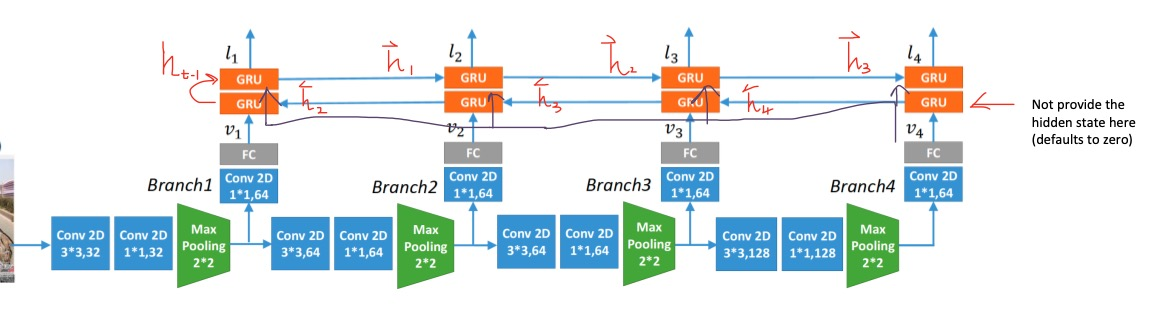

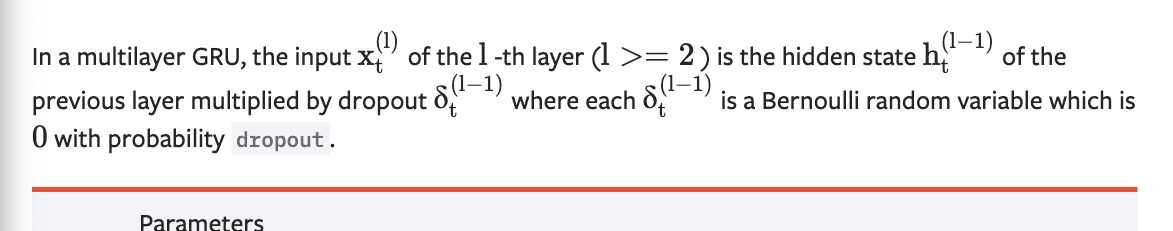

# Pytorch Tutorial: Training on GRU. the previous class is redefined

- https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html

In [19]:
class CNN_BiGRU(CNN):
    def __init__(self, image_height, image_width, hidden_size, num_layers):
        super(CNN_BiGRU, self).__init__(image_height, image_width)

        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # The Bi-GRU with 1 layer in Bi-directions (forward layer + backward layer)
        self.bigru = nn.GRU(input_size = 64, hidden_size = hidden_size, num_layers = num_layers, batch_first = True, bidirectional=True)

        self.flatten = nn.Flatten(1, -1)
        self.bn = nn.BatchNorm1d(4*2*hidden_size)
        self.fc = nn.Linear(4*2*hidden_size, 2) # 4 -> sequence_length, *2 because we set bidirectional = True

    def forward(self, x):
        _, _, _, _, v_cat, _ = super().forward(x)
        # print(v1.shape)
        # v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (N, 64) --> (1, N, 64)
        # v2 = v2.unsqueeze(0)
        # v3 = v3.unsqueeze(0)
        # v4 = v4.unsqueeze(0)
        # v_cat = torch.cat((v1, v2, v3, v4), dim=0) # (1, N, 64) --> (4, N, 64)

        # v_cat = v_cat.permute(1,0,2) # (4, N, 64) --> (N, 4, 64) since we set batch_first = True
        # print(v_cat.shape)

        input = v_cat.reshape(-1, 64, 4).permute(0, 2, 1)   # 64 is hard coded
        out, h = self.bigru(input)  # hidden  default is a 0 tensor

        L_cat = self.flatten(out) # (N, 4, num_directions*hidden_size)

        out = self.fc(self.bn(L_cat)) # (N, 4*num_directions*hidden_size)

        return L_cat, out
        

In [20]:
class CNN_GRU(CNN):
    def __init__(self, image_height, image_width):
        super(CNN_GRU, self).__init__(image_height, image_width)
        # if input size = (batch_size(N),  channels = 3,  image height = 128, image width = 128)

        # The 4 GRUs in layer 1
        self.gru1_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_1 = nn.GRU(input_size=64, hidden_size=32, num_layers=1, bidirectional=False)

        # The 4 GRUs in layer 2
        self.gru1_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru2_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru3_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)
        self.gru4_2 = nn.GRU(input_size=32, hidden_size=32, num_layers=1, bidirectional=False)

        self.gru_simple = nn.GRU(input_size=64, hidden_size=32, num_layers=2, bidirectional=True)

        self.relu = nn.ReLU()

        self.bn = nn.BatchNorm1d(4*2*32)
        self.fc = nn.Sequential(nn.Linear(4*2*32, 2))
                                            # nn.LogSoftmax(dim=1)) # AG: no need for softmax if we use cross entropy loss function, which will also offer prob.
                                                            # Now the loss in the training part converges!!

    def forward(self, x):
        v1, v2, v3, v4, v_cat, _ = super().forward(x)
        
        v1 = v1.unsqueeze(0) # add an extra dimension to feed into the gru model (4, 64) --> (1, 4, 64)
        v2 = v2.unsqueeze(0)
        v3 = v3.unsqueeze(0)
        v4 = v4.unsqueeze(0)

        # backward GRU (1st layer) which reads from v4 to v1 
        out4_layer1, h4_backward = self.gru4_1(v4)
        out3_layer1, h3_backward = self.gru3_1(v3, h4_backward)
        out2_layer1, h2_backward = self.gru2_1(v2, h3_backward)
        out1_layer1, h1_backward = self.gru1_1(v1, h2_backward)

        # print('h4_backward=',h4_backward)
        # print('h3_backward=',h3_backward)

        # print(out4_layer1.shape)   # --> (1, N, 32)
        # print(h1_backward.shape)   # --> (1, N, 32)


        # forward GRU (2nd layer) which reads from v1 to v4 
        out1_layer2, h1_forward = self.gru1_2(h1_backward)
        out2_layer2, h2_forward = self.gru2_2(h2_backward, h1_backward)
        out3_layer2, h3_forward = self.gru3_2(h3_backward, h2_backward)
        out4_layer2, h4_forward = self.gru4_2(h4_backward, h3_backward)

        # out1_layer2, h1_forward = self.gru1_2(out1_layer1, h1_backward)
        # out2_layer2, h2_forward = self.gru2_2(out2_layer1, h1_backward)
        # out3_layer2, h3_forward = self.gru3_2(out3_layer1, h2_backward)
        # out4_layer2, h4_forward = self.gru4_2(out4_layer1, h3_backward)

        # print('h1_forward=',h1_forward)
        # print('h2_forward=',h2_forward)

        # print(out1_layer2.shape)  # --> (1, N, 32)
        # print(h1_forward.shape)   # --> (1, N, 32)

        # concatenating the forward hidden state and the backward hidden state along the feature dimension --> (1, N, 64)
        L1 = torch.squeeze(torch.cat((h1_forward, h1_backward), dim=2)) # --> (N, 64)
        L2 = torch.squeeze(torch.cat((h2_forward, h2_backward), dim=2))
        L3 = torch.squeeze(torch.cat((h3_forward, h3_backward), dim=2))
        L4 = torch.squeeze(torch.cat((h4_forward, h4_backward), dim=2))

        # print("\n L1 size:", L1.shape)
        # print("\n L2 size:", L2.shape)
        # print("\n L3 size:", L3.shape)
        # print("\n L4 size:", L4.shape)

        L_cat = torch.cat((L1, L2, L3, L4), dim=1)

        # print("\n L_cat size:", L_cat.shape)
        
        p = self.fc(self.bn(L_cat))

        return L1, L2, L3, L4, L_cat, p


    # def init_hidden(self, batch_size):

    #     weight = next(self.parameters()).data
    #     hidden = weight.new(1, batch_size, 32).zero_().to(device)
    #     return hidden


In [15]:
#Code:
from sklearn.metrics import accuracy_score # normal accuracy
from sklearn.metrics import balanced_accuracy_score # used in case of imbalanced data sets, average of recall, from 0 to 1
from sklearn.metrics import confusion_matrix # division of performance on the multilabels
from sklearn.metrics import cohen_kappa_score # compares model against random prediction, from -1 to 1
from sklearn.metrics import classification_report # for multilabel classification, gives precision, recall, f score, support, more

def print_metrics(y_true, y_pred, target_names):
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Balanced Accuracy:" , balanced_accuracy_score(y_true, y_pred))
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("Cohen Kappa Score:", cohen_kappa_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred, target_names=target_names))

# Loading data and training

In [21]:
# Hyper-parameters
hidden_size = 32  # for GRU
num_layers = 1    # for GRU
learning_rate = 0.0001
batch_size = 32
MAXepoch = 300
resumetraining = False

# Load training and test sets
train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True, drop_last=True) 
val_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = True, drop_last=True)

# Which model to use?
modelname = ['CNN', 'CNN_BiGRU', 'CNN_GRU']
m = 1

if m == 0:
  model = CNN(image_height, image_width)
elif m == 1:
  model = CNN_BiGRU(image_height, image_width, hidden_size, num_layers)
elif m == 2:
  model = CNN_GRU(image_height, image_width)

# Device configuration
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") 

model.to(device) # initialize the model on device

# Loss and optimizer
criterion = nn.CrossEntropyLoss() # This criterion combines LogSoftmax and NLLLoss in one single class.
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)


resume_epoch = 0
# Resume the last trained model?
if resumetraining == True:
  # load the model checkpoint
  PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname[m] + "_MAXepoch" + str(MAXepoch)
          + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + ".pth")
  print('Loading from ', PATH)

  checkpoint = torch.load(PATH)
  # load model weights state_dict
  model.load_state_dict(checkpoint['model_state_dict'])
  print('Previously trained model weights state_dict loaded...')

  # load trained optimizer state_dict
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  print('Previously trained optimizer state_dict loaded...')

  resume_epoch = checkpoint['epoch']
  # load the criterion
  criterion = checkpoint['loss']
  print('Trained model loss function loaded...')
  print('\n===== Resuming the Last Training from Epoch %d ... =====' %(resume_epoch))

else:
  print('\n===== Start a New Training ... =====')
  

# print('\n===== Start Training over one image (testing the model) ... =====')
# train_data, labels = next(iter(train_loader))
# # plot training images
# np_image = train_data[0,:,:,:].cpu().numpy() #converting tensor --> numpy
# np_image = np.transpose(np_image, (1,2,0))
# image_show(np_image)

for epoch in range(MAXepoch - resume_epoch):
  count = 0
  samples = 0
  correct = 0
  t0 = time.time()

  epoch = epoch + resume_epoch
  # Training
  for count, (train_data, labels) in tqdm(enumerate(train_loader), total=int(len(train_set)/train_loader.batch_size), miniters = 10):
    # if count == 11:
    #   break

    train_data =  train_data.to(device)
    labels = labels.to(device)

    # Forward pass
    if m == 0 or m == 2:
      _, _, _, _, _, outputs = model(train_data) # outputs.shape = (N, 2)
    elif m == 1:
      _, outputs = model(train_data) # outputs.shape = (N, 2)

    loss = criterion(outputs, labels)

    # Backward and optimize
    optimizer.zero_grad() 
    loss.backward()

    if m == 1 or m == 2: # Clipping gradients for GRU/LSTM/RNN to avoid exploding gradients!
      torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) 

    optimizer.step()

    _, predicted = torch.max(outputs.data, dim=1) # returns indices of the largest prob. --> the predicted label
    samples += labels.size(0)
    correct += (predicted == labels).sum().item()

    if (count+1) % 10 == 0:
        accuracy = 100 * correct / samples
        print(modelname[m], ': Epoch: %d/%d  Train Loss: %5f  Train Accuracy: %5f' %(epoch+1, MAXepoch, loss.item(), accuracy))
        
    # Early stopper
    if loss.item() < 0.1:
      print('Training is stopped at Epoch %d as loss is already very low!' %(epoch+1))
      print(loss.item())
      break
      
  t1 = time.time()
  print("Training Time: %10.3f mins" %((t1-t0)/60))

  if (epoch+1) % 10 == 0 or epoch+1 == 1:
    # Validating
    model.eval()  # Toggle on evaluation mode to disable dropout/batchnorm layers when doing validation!!
    val_running_loss = 0.0
    val_running_correct = 0
    preds_all = np.array([])
    labels_all = np.array([])
    with torch.no_grad():
        print('\n===== Start Validating ... =====')
        for count, (val_data, labels) in enumerate(val_loader):
            val_data = val_data.to(device)
            labels = labels.to(device)

            if m == 0:
              _, _, _, _, _, outputs = model(val_data) # outputs.shape = (N, 2)
            elif m == 1:
              _, outputs = model(val_data) # outputs.shape = (N, 2)

            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == labels).sum().item()
        
            # For classficiation report later
            preds_all = np.concatenate([preds_all, preds.cpu().int()]) # convert to cpu int type, and then concatenate 
            labels_all = np.concatenate([labels_all,   labels.cpu().int()])   

        val_loss = val_running_loss/len(val_loader.dataset)
        val_accuracy = 100. * val_running_correct/len(val_loader.dataset)   

    print(modelname[m], ': Epoch: %d/%d  Val Loss: %5f  Val Accuracy: %5f' %(epoch+1, MAXepoch, val_loss, val_accuracy))
    model.train() # Toggle on the training mode to enable back the dropout/batchnorm layers for training!!

    # Print classification report
    y_pred = preds_all
    y_true = labels_all
    target_names = ['non-rumor', 'rumor']
    print_metrics(y_true, y_pred, target_names)

    # Save model checkpoint
    print('Saving model if needing to resume training later.')
    PATH = ('drive/My Drive/Colab Notebooks/trained_models/' + modelname[m] + "_MAXepoch" + str(MAXepoch)
            + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + ".pth")
    torch.save({
          'epoch': epoch+1,
          'model_state_dict': model.state_dict(),
          'optimizer_state_dict': optimizer.state_dict(),
          'loss': criterion,
          }, PATH)

print('\n===== Finished Training & Validating =====')



  0%|          | 0/331 [00:00<?, ?it/s]


===== Start a New Training ... =====




  3%|▎         | 10/331 [00:05<02:46,  1.93it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.692009  Train Accuracy: 53.437500




  6%|▌         | 20/331 [00:10<02:44,  1.89it/s]

CNN_BiGRU : Epoch: 1/300  Train Loss: 0.727968  Train Accuracy: 53.125000


KeyboardInterrupt: ignored

# Save the trained model to local drive and load from it

In [ ]:
# Specify a path to your local drive
PATH = 'drive/My Drive/Colab Notebooks/' + modelname[m] + "_epoch" + str(epoch+1) + "_batch" + str(batch_size) + "_lr" + str(learning_rate) + ".pt"
print(PATH)

# Save the trained model
torch.save(net, PATH)

# Validating model

In [ ]:
# Load the trained model
trained_net = torch.load(PATH)
# trained_net = torch.load('drive/My Drive/Colab Notebooks/CNN_BiGRU_epoch50_batch64_lr0.01.pt')

# Validating
trained_net.eval() # This is important to remove dropout/batchnorm layers as we don't want to use them when doing validation!!
val_running_loss = 0.0
val_running_correct = 0
preds_all = np.array([])
labels_all = np.array([])
with torch.no_grad():
    print('\n===== Start Validating ... =====')
    for count, (val_data, labels) in enumerate(val_loader):
        val_data = val_data.to(device)
        labels = labels.to(device)
        if m == 0:
          _, _, _, _, _, outputs = trained_net(val_data) # outputs.shape = (N, 2)
        elif m == 1:
          _, outputs = trained_net(val_data) # outputs.shape = (N, 2)

        loss = criterion(outputs, labels)
        
        val_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        val_running_correct += (preds == labels).sum().item()
    
        # For classficiation report later
        preds_all = np.concatenate([preds_all, preds.cpu().int()]) # convert to cpu int type, and then concatenate 
        labels_all = np.concatenate([labels_all,   labels.cpu().int()])   

    val_loss = val_running_loss/len(val_loader.dataset)
    val_accuracy = 100. * val_running_correct/len(val_loader.dataset)   
print(modelname[m], ': Val Loss: %5f  Val Accuracy: %5f' %(val_loss, val_accuracy))

# Classification report
y_pred = preds_all
y_true = labels_all

target_names = ['non-rumor', 'rumor']
print_metrics(y_true, y_pred, target_names)

# Backup codes (not use now)

In [ ]:
# training function
def fit(model, dataloader, optimizer, criterion, train_data):
    print('Training...')
    model.train()
    train_running_loss = 0.0
    train_running_correct = 0
    for i, data in tqdm(enumerate(dataloader), total=int(len(train_data)/dataloader.batch_size)):
        data, target = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, target)
        train_running_loss += loss.item()
        _, preds = torch.max(outputs.data, 1)
        train_running_correct += (preds == target).sum().item()
        loss.backward()
        optimizer.step()
        
    train_loss = train_running_loss/len(dataloader.dataset)
    train_accuracy = 100. * train_running_correct/len(dataloader.dataset)    
    return train_loss, train_accuracy

In [ ]:
# validation function
def validate(model, dataloader, optimizer, criterion, val_set):
    print('Validating...')
    model.eval()
    val_running_loss = 0.0
    val_running_correct = 0
    with torch.no_grad():
        for count, (val_data, labels) in tqdm(enumerate(dataloader), total=int(len(val_set)/dataloader.batch_size), miniters = 10):
            val_data = val_data.to(device)
            labels = labels.to(device)
            outputs = model(val_data)
            loss = criterion(outputs, labels)
            
            val_running_loss += loss.item()
            _, preds = torch.max(outputs.data, 1)
            val_running_correct += (preds == labels).sum().item()
        
            # For classficiation report later
            preds_all = np.concatenate([predicted_all, preds.cpu().int()]) # convert to cpu int type, and then concatenate 
            labels_all = np.concatenate([labels_all,   labels.cpu().int()])   

        val_loss = val_running_loss/len(dataloader.dataset)
        val_accuracy = 100. * val_running_correct/len(dataloader.dataset)    

        return val_loss, val_accuracy, predicted_all, labels_all